<a href="https://colab.research.google.com/github/gogooma9/SolarGen/blob/gogooma9/src/solar_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/drive/MyDrive/SolarGen/'

## Baseline

In [ ]:
train = pd.read_csv(data_path + './data/train/train.csv')
submission = pd.read_csv(data_path + './data/sample_submission.csv')

In [ ]:
# Local Outlier Factor(LOF)

from sklearn.neighbors import LocalOutlierFactor
import scipy.interpolate as interpolate


def LOF(data, neighbors = 20 ,conta =0.01):
    temp = data.copy()
    temp = temp[['DHI', 'DNI']]

    clf = LocalOutlierFactor(n_neighbors = neighbors, contamination = conta , p = 2)
    y_pred = clf.fit_predict(temp)

    return y_pred

# Tuning parameter
# p = 1 or 2
# neighbors
# conta
# number of variables

train_afterLOF = pd.DataFrame(LOF(train, 22, 0.005))

outlier_idx = train_afterLOF[train_afterLOF[0] < 1].index
print(len(outlier_idx))

train.drop(outlier_idx, axis=0, inplace=True)

new_idx = [i for i in range(0,52560)]
added_idx_train = train.reindex(new_idx)
train = added_idx_train.interpolate(method = 'linear',limit_direction='forward')
train

263


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0
1,0.0,0.0,30.0,0.0,0.0,1.5,69.06,-12.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.6,71.78,-12.0,0.0
3,0.0,1.0,30.0,0.0,0.0,1.6,71.75,-12.0,0.0
4,0.0,2.0,0.0,0.0,0.0,1.6,75.20,-12.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094.0,21.0,30.0,0.0,0.0,2.4,70.70,-4.0,0.0
52556,1094.0,22.0,0.0,0.0,0.0,2.4,66.79,-4.0,0.0
52557,1094.0,22.0,30.0,0.0,0.0,2.2,66.78,-4.0,0.0
52558,1094.0,23.0,0.0,0.0,0.0,2.1,67.72,-4.0,0.0


In [ ]:
# Isolation Forest

from sklearn.ensemble import IsolationForest
import scipy.interpolate as interpolate

rng = np.random.RandomState(42)

def IsoForest(data, est = 100, max_s = "auto", conta = 0.01, random = rng, warm = True):
    temp = data.copy()
    temp = temp[['DHI', 'DNI', 'WS', 'RH', 'T']]

    clf = IsolationForest(n_estimators = est, max_samples = max_s, contamination = conta, random_state=random, warm_start = warm )
    clf.fit(temp)
    y_pred = clf.predict(temp)

    return y_pred

# train_afterISO = pd.DataFrame(IsoForest(train))

# outlier_idx = train_afterISO[train_afterISO[0] < 1].index

# train.drop(outlier_idx, axis=0, inplace=True)

# new_idx = [i for i in range(0,52560)]
# added_idx_train = train.reindex(new_idx)
# added_idx_train
# train = added_idx_train.interpolate(method = 'linear',limit_direction='forward')
# train

In [ ]:
#InterQuantile Range(IQR)

def get_outlier(df=None, column=None, weight=1.5): 
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR * weight
  
  min = quantile_25 - IQR_weight
  max = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < min) | (df[column] > max) ].index
  return outlier_idx


# columns = ['DHI', 'DNI', 'WS', 'RH', 'T']
# for col in columns:
  # delete_data = get_outlier(df=train, column=col, weight=1.5)
  # try:
    # train.drop(delete_data, axis=0, inplace=True)
  # except KeyError as e:
    # pass

# new_index = [i for i in range(0,52560)]
# data1 = train.reindex(new_index)
# train = data1.fillna(method='ffill')
# train

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5409ba080>,
      dtype=object)

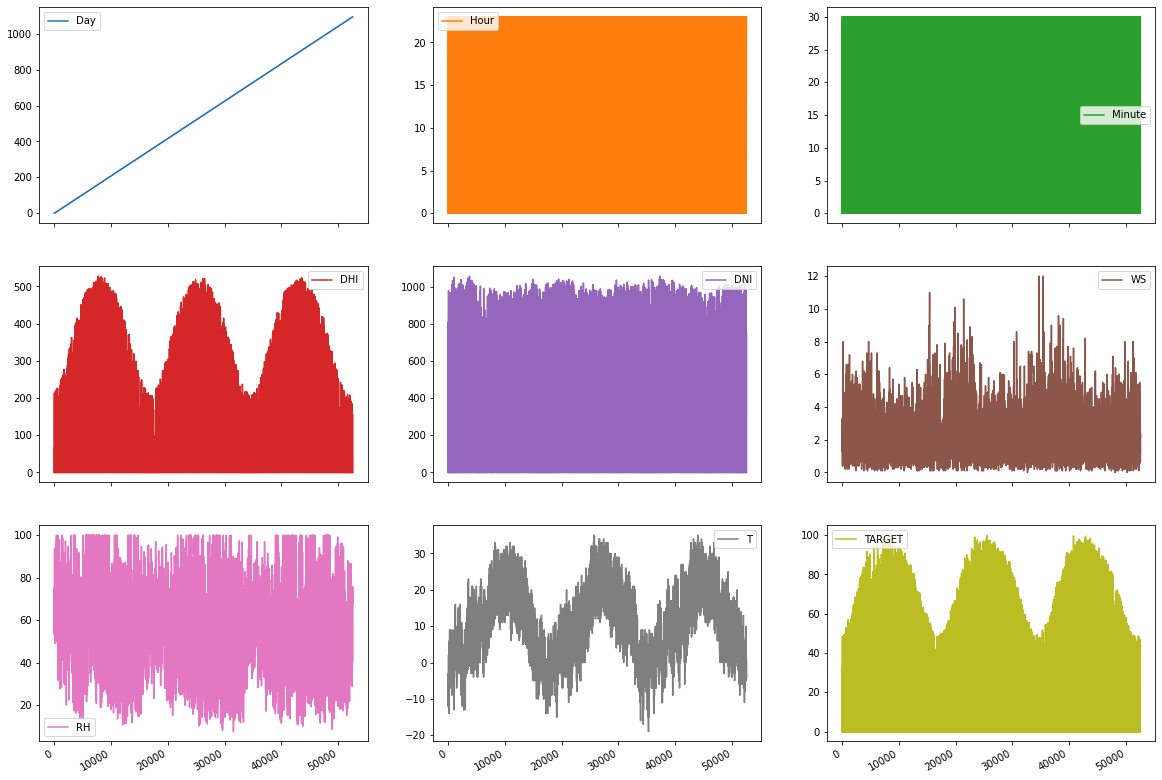

In [ ]:
import matplotlib.pyplot as plt

train.plot(subplots=True, layout=(3,3), figsize=(20,15))

In [ ]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]


df_train = preprocess_data(train)
df_train.iloc[:48]

,Hour,TARGET,DHI,DNI,WS,RH,T,Target1,Target2
0,0.0,0.000000,0.0,0.0,1.50,69.080,-12.0,0.000000,0.000000
1,0.0,0.000000,0.0,0.0,1.50,69.060,-12.0,0.000000,0.000000
2,1.0,0.000000,0.0,0.0,1.60,71.780,-12.0,0.000000,0.000000
3,1.0,0.000000,0.0,0.0,1.60,71.750,-12.0,0.000000,0.000000
4,2.0,0.000000,0.0,0.0,1.60,75.200,-12.0,0.000000,0.000000
5,2.0,0.000000,0.0,0.0,1.50,69.290,-11.0,0.000000,0.000000
6,3.0,0.000000,0.0,0.0,1.50,72.560,-11.0,0.000000,0.000000
7,3.0,0.000000,0.0,0.0,1.40,72.550,-11.0,0.000000,0.000000
8,4.0,0.000000,0.0,0.0,1.30,74.620,-11.0,0.000000,0.000000
9,4.0,0.000000,0.0,0.0,1.30,74.610,-11.0,0.000000,0.000000


In [ ]:
df_test = []

for i in range(81):
    file_path = data_path + './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [ ]:
X_test.head()

,Hour,TARGET,DHI,DNI,WS,RH,T
288,0,0.0,0,0,0.8,80.92,-2.8
289,0,0.0,0,0,0.9,81.53,-2.9
290,1,0.0,0,0,1.0,79.91,-3.0
291,1,0.0,0,0,0.9,79.91,-3.0
292,2,0.0,0,0,0.9,77.20,-3.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [ ]:
# Target 예측
import sys
from io import StringIO

def get_best_quantiles(data):

    best_indexes = []
    best_quantiles = {}

    lines = data.splitlines()

    for i, line in enumerate(lines):
        if "best" in line or "Best" in line:
            best_indexes.append(i+1)

    for i in range(9):
        key = (i+1) * 0.1
        val = float(lines[best_indexes[i]].split(":")[-1].strip())
        best_quantiles[key] = val

    return best_quantiles

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()
    
    old_stdout = sys.stdout
    sys.stdout = my_stdout = StringIO()
    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)
    
    sys.stdout = old_stdout
    results_out = my_stdout.getvalue()
    LGBM_losses = get_best_quantiles(results_out)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred, LGBM_losses

In [ ]:
# Target1
models_1, results_1, loss_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
for key, val in loss_1.items():
    print("[%.1f]"%key + "\t%f"%val)
print("[avg]\t%.6f"%np.average(list(loss_1.values())))

[0.1]	1.366030
[0.2]	2.160940
[0.3]	2.551580
[0.4]	2.624150
[0.5]	2.530340
[0.6]	2.288040
[0.7]	1.880490
[0.8]	1.373910
[0.9]	0.768285
[avg]	1.949307


In [ ]:
# Target2
models_2, results_2, loss_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
for key, val in loss_2.items():
    print("[%.1f]"%key + "\t%f"%val)
print("[avg]\t%.6f"%np.average(list(loss_2.values())))

[0.1]	1.375290
[0.2]	2.201490
[0.3]	2.583910
[0.4]	2.695220
[0.5]	2.598270
[0.6]	2.323620
[0.7]	1.917150
[0.8]	1.381140
[0.9]	0.771283
[avg]	1.983041


In [ ]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# submission.to_csv(data_path + './data/submission.csv', index=False)